In [1]:
!pip install numpy
!pip install matplotlib
!pip install scikit-image
!pip install pillow
!pip install opencv-python
!pip install timm
!pip install tqdm
# Check is at least python 3.9
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
from typing import Callable
import os
from datetime import datetime
from enum import Enum
import random
from skimage.color import rgb2gray, rgb2hsv
from skimage import filters
from skimage import segmentation
from skimage.morphology import remove_small_holes, remove_small_objects
import cv2 as cv


In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import timm
import torchvision
from torchvision.models.vision_transformer import vit_b_16
from torchvision.models import ViT_B_16_Weights

c:\Users\Tonio\miniconda3\envs\iapr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import platform

# Get os name
os_name = platform.system().lower()
num_workers = 8

# OS X
if 'darwin' in os_name:
    print("Detected OS X")
    %pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.1
# Linux 
elif 'linux' in os_name:
    print("Detected Linux")
    %pip install torch==1.8.1 torchvision==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
# Windows 
else:
    print("Detected Windows")
    num_workers = 0  # Hard fix for Windows users
    %pip install torch==1.12.0 torchvision==0.13 -f https://download.pytorch.org/whl/torch_stable.html


Detected Windows
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [5]:
class ImageType(Enum):
    NEUTRAL = "1. neutral_bg"
    NOISY = "2. noisy_bg"
    HAND = "3. hand"
    NEUTRAL_OOD = "4. neutral_bg_outliers"
    NOISY_OOD = "5. noisy_bg_outliers"
    HAND_OOD = "6. hand_outliers"
    
def loadImageOfType(type: ImageType, downsample: int = 1, grayscale: bool = False):
    # directory = f"./data/train/{type}"
    directory = os.path.join(".", "data", "train", type.value)
    images = os.listdir(directory)
    img = np.array(Image.open(os.path.join(directory, random.choice(images)))) 
    if downsample > 1:
        img = img[::downsample, ::downsample, :]
    if grayscale:
        img = (rgb2gray(img)*255).astype(np.uint8)
        
    # img = filters.sobel(img)
    
    return img
        


## Preprocessing

In [6]:
def filter_circles(circle_array):
    # print(circle_array)
    # Convert the array to a NumPy array
    
    # Find unique center coordinates
    unique_centers, unique_indices = np.unique(circle_array[:, :2], axis=0, return_index=True)
    # print(unique_indices)
    
    # Get the indices of circles with largest radius for each unique center
    largest_circles = []
    for center in unique_centers:
      largest_circle = np.array((center[0], center[1], 0))
      for j in range(len(circle_array)):
        circle = circle_array[j]
        if (circle[0] == center[0] and circle[1]==center[1] and circle[2] > largest_circle[2]):
          largest_circle[2] = circle[2] 
      largest_circles.append(largest_circle)
  
    # print(largest_circles)
               
      

    # # Convert the list of indices to a NumPy array
    # max_radius_indices = np.array(max_radius_indices)
    # print(max_radius_indices)
    
    return np.array(largest_circles)

In [7]:
# the input is a cv image so x and y are swapped
def extract_circles_images(x, y, r, img, down):
    factor = r + 10
    left = (x - factor)*down
    right = (x + factor)*down
    up = (y - factor)*down
    bottom = (y + factor)*down
    output = img.copy()
    output[:, :, 0] = img[:, :, 2]
    output[:, :, 2] = img[:, :, 0]
    return output[up:bottom, left:right, :]

In [8]:
def find_circles(path, debug = False):
    img = cv.imread(path)
    full_size_img = img.copy()
    down = 3
    size = (int(img.shape[1]/down), int(img.shape[0]/down))
    img = cv.resize(img, size, interpolation=cv.INTER_LINEAR)

    output = img.copy()
    output[:, :, 0] = img[:, :, 2]
    output[:, :, 2] = img[:, :, 0]
    img[:, :, 2] = 0


	# canny = cv.Canny(gray, 100, 200)
	# plt.imshow(canny, cmap="gray")
	# plt.show()


    gray = cv.blur(cv.cvtColor(img, cv.COLOR_BGR2GRAY), (8, 8))

    # detect circles in the image
    circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT_ALT, dp=1, minDist = 50, minRadius=50, maxRadius=200, param1=5, param2=0.6)
    # ensure at least some circles were found
    circles_imgs = []
    if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        circles = filter_circles(circles)
        print(f"detected {len(circles)} circles")
    
        for (x, y, r) in circles:
            # print(x, y, r)
            # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
            cv.circle(output, (x, y), r, (0, 255, 0), 4)
            cv.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 255, 0), -1)
            new_circle = extract_circles_images(x, y, r, full_size_img, down)
            circles_imgs.append(new_circle)
            if debug:
                plt.imshow(new_circle)
                plt.show()
            # circles_imgs.append(extract_circles_images(x, y, r, output))
    
        # show the output image
    if debug:
        plt.imshow(output)
        plt.show()
    return circles_imgs

In [9]:
def get_training_data_paths():
    training_paths = []
    base_dir = "./data/train/"
    for d in os.listdir(base_dir):
        training_dir = f"{base_dir}/{d}"
        for path in os.listdir(training_dir):
            file_path = f"{training_dir}/{path}"
            training_paths.append(file_path)
            # print(file_path)
    return training_paths
        
# get_training_data_paths()

In [10]:
def get_label_for_image(path):
    filename = path.split("/")[-1].split(".")[0]

    data = np.genfromtxt('./data/train_labels.csv', delimiter=',', dtype=str)

# Assume the first column contains the strings you want to search through
    first_column = data[:, 0]

    # Find the index of the first entry that matches your string
    index = np.where(first_column == filename)[0]
    
    if index.size > 0:
        # print(f"The first entry matching '{filename}' is at index {index[0]}.")
        #we add 0 in order to account for non coins
        label_vector = np.append(data[index[0]][1:], 0)
        # print(label_vector)
        return torch.from_numpy(label_vector.astype(np.float32))
        # You can access the corresponding row using data[index[0]]
    else:
        # print(f"No entry matching '{filename}' found.")
        return torch.zeros(0)


detected 5 circles


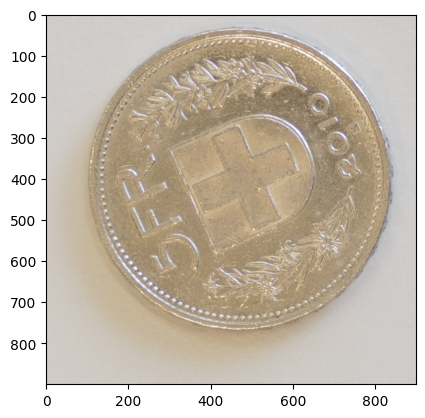

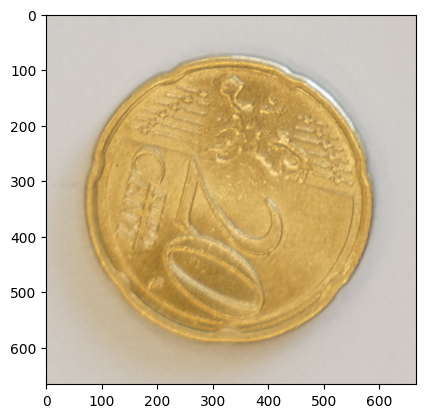

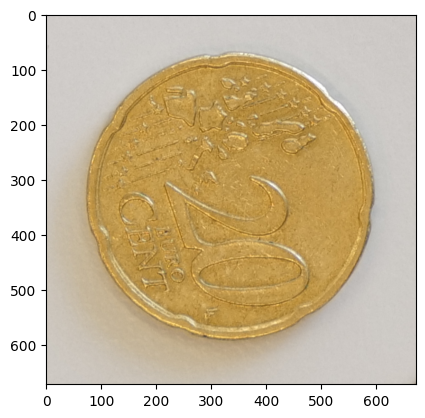

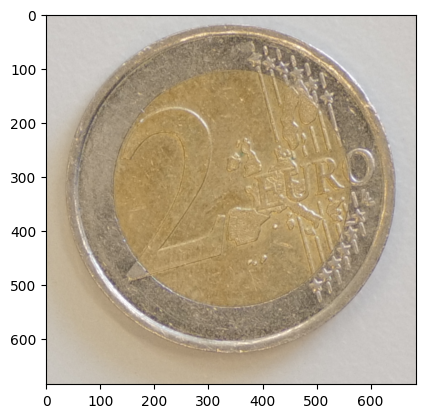

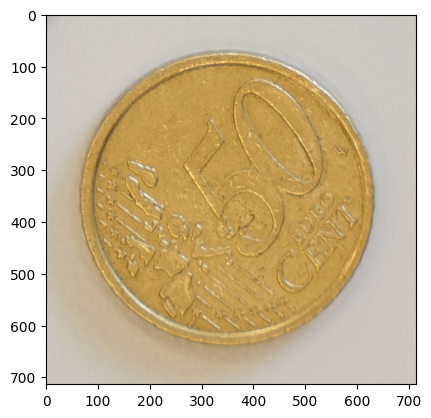

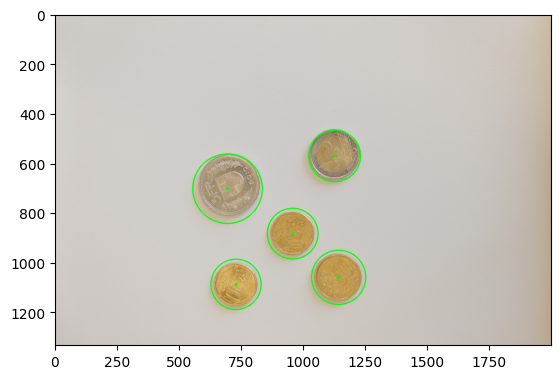

In [11]:
# d = "./data/train/1. neutral_bg//"
# d = "./data/train/2. noisy_bg///"
# d = "./data/train/3. hand///"
d = "./data/train/5. noisy_bg_outliers/"
# d = "./data/train/6. hand_outliers///"
# d = "./data/test//"
# for f in os.listdir(d):

paths = get_training_data_paths()
p = paths[0]
if get_label_for_image(p).shape[0] == 0:
    print("wrong filename")

circles = find_circles(paths[0], debug=True)
# for path in get_training_data_paths():
# img = cv.imread(f"{d}/{f}")[::3, ::3].astype(np.uint8)
# img[:, :, 1] = 0



In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [13]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
resnet152 = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2).to(device)
def extract_features(input_image):
    # or any of these variants
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
    resnet152.eval()
    feature_extractor = torch.nn.Sequential(*list(resnet152.children())[:-1])

    image_dim = torch.tensor([input_image.shape[0]]).to(device)
    # print(image_dim)

    input_image = Image.fromarray(input_image)
    # input_image.show()
    preprocess = transforms.Compose([
        # transforms.Resize(256),
        transforms.CenterCrop(850),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    
    # plt.imshow(input_tensor.permute(1, 2, 0))
    # plt.show()
    
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available

    input_batch = input_batch.to(device)
    feature_extractor.to(device)

    with torch.no_grad():
        features = feature_extractor(input_batch)
    # Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
    # print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    # probabilities = torch.nn.functional.softmax(output[0], dim=0)
    features = torch.flatten(features)
    # features = torch.cat((features, image_dim))

    # print(features.size())
    return features




In [14]:
for circle in circles:
    # print(extract_features(circle).shape)
    print(extract_features(circle).shape)

torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])


In [15]:
def get_test_data_paths():
    test_paths = []
    base_dir = "./data/test/"
    for path in os.listdir(base_dir):
        file_path = f"{base_dir}/{path}"
        test_paths.append(file_path)
            # print(file_path)
    return test_paths



## Training on individual coin

In [16]:
class_names = ["chf_5", "chf_2", "chf_1", "chf_0.5", "chf_0.2", "chf_0.1", "chf_0.05", "eur_2", "eur_1", "eur_0.5", "eur_0.2", "eur_0.1", "eur_0.05", "eur_0.02", "eur_0.01", "OOD", "bg"]


In [17]:
def get_training_set_size():
    size = 0
    for index, c in enumerate(class_names):
        labeled_coins_dir = "./data/labeled_coins/"
        selected_dir = f"{labeled_coins_dir}{c}"
        files = os.listdir(selected_dir)
        size += len(files)
    return size

print(get_training_set_size())

578


### background classifier

In [18]:

data_set_size = get_training_set_size()

trainX_bg = torch.zeros((data_set_size, 2048)).to(device)
trainY_bg = torch.zeros(data_set_size).to(device)

data_index = 0

for index, c in enumerate(class_names):
    print(f"extracting class {index}")
    labeled_coins_dir = "./data/labeled_coins/"
    selected_dir = f"{labeled_coins_dir}{c}"
    files = os.listdir(selected_dir)
    for j, file in enumerate(files):
        selected_file_path = f"{selected_dir}/{file}"
        coin = Image.open(selected_file_path)
        # degrees = random.randint(0, 360)
        # coin = coin.rotate(degrees, resample=Image.BICUBIC)
    #     # coin.show()
        
    #     """
    #     extracting features + training
    #     """

    #     optimizer.zero_grad()
        x = extract_features(np.array(coin))
        trainX_bg[data_index] = x
        val_y = 0
        if (index == class_names.index("bg")):
            val_y = 1
        trainY_bg[data_index] = val_y

        
        data_index += 1


extracting class 0
extracting class 1
extracting class 2
extracting class 3
extracting class 4
extracting class 5
extracting class 6
extracting class 7
extracting class 8
extracting class 9
extracting class 10
extracting class 11
extracting class 12
extracting class 13
extracting class 14
extracting class 15
extracting class 16


In [19]:
bg_classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 1), 
    torch.nn.Sigmoid()
)

bg_classifier = bg_classifier.to(device)

In [20]:
criterion_bg = torch.nn.BCELoss()
optimizer_bg = torch.optim.Adam(bg_classifier.parameters(), lr=5e-4)


trainY_bg = trainY_bg.unsqueeze(0).view(-1, 1)
# print(trainY_ood)


nb_epochs = 1200

for epoch in range(nb_epochs):
    optimizer_bg.zero_grad()
            
    pred_bg = bg_classifier(trainX_bg)
    # print(pred_ood)
    # print(pred.shape)
    loss_bg = criterion_bg(pred_bg, trainY_bg.to(device)) 
    loss_bg.backward() 
    # print(f"loss at epoch {epoch} - {loss}")
    if epoch %50 == 0:
        print(f"loss at {epoch} - {loss_bg}")
    optimizer_bg.step() 
        

loss at 0 - 0.6995975375175476
loss at 50 - 0.029269466176629066
loss at 100 - 0.01037945318967104
loss at 150 - 0.004755298141390085
loss at 200 - 0.0026392252184450626
loss at 250 - 0.0016702179564163089
loss at 300 - 0.0011515103979036212
loss at 350 - 0.0008421795209869742
loss at 400 - 0.0006429085624404252
loss at 450 - 0.0005069734179414809
loss at 500 - 0.00041005027014762163
loss at 550 - 0.00033847367740236223
loss at 600 - 0.00028407559148035944
loss at 650 - 0.0002417559880996123
loss at 700 - 0.00020816798496525735
loss at 750 - 0.00018106114293914288
loss at 800 - 0.0001588645827723667
loss at 850 - 0.00014045275747776031
loss at 900 - 0.0001250129280379042
loss at 950 - 0.00011193504906259477
loss at 1000 - 0.00010075623140437528
loss at 1050 - 9.113265696214512e-05
loss at 1100 - 8.278332825284451e-05
loss at 1150 - 7.549405563622713e-05


### training ood classifier

In [21]:
data_set_size = get_training_set_size() - len(os.listdir(labeled_coins_dir+"bg"))

trainX_ood = torch.zeros((data_set_size, 2048)).to(device)
trainY_ood = torch.zeros(data_set_size).to(device)

data_index = 0

for index, c in enumerate(class_names):
    if index == len(class_names) - 1: continue
    print(f"extracting class {index}")
    labeled_coins_dir = "./data/labeled_coins/"
    selected_dir = f"{labeled_coins_dir}{c}"
    files = os.listdir(selected_dir)
    for j, file in enumerate(files):
        selected_file_path = f"{selected_dir}/{file}"
        coin = Image.open(selected_file_path)
        # degrees = random.randint(0, 360)
        # coin = coin.rotate(degrees, resample=Image.BICUBIC)
    #     # coin.show()
        
    #     """
    #     extracting features + training
    #     """

    #     optimizer.zero_grad()
        x = extract_features(np.array(coin))
        trainX_ood[data_index] = x
        val_y = 0
        if (index == class_names.index("OOD")):
            val_y = 1
        trainY_ood[data_index] = val_y

        
        data_index += 1




 


extracting class 0
extracting class 1
extracting class 2
extracting class 3
extracting class 4
extracting class 5
extracting class 6
extracting class 7
extracting class 8
extracting class 9
extracting class 10
extracting class 11
extracting class 12
extracting class 13
extracting class 14
extracting class 15


In [22]:
print(trainY_ood)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

#### svm test -- not used for the moment

In [23]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(trainX_ood.cpu(), trainY_ood.cpu(), test_size=0.3, random_state=42)

# Initialize the SVM classifier with desired parameters
clf = svm.SVC(kernel='linear', C=1.0)  # You can choose other kernels like 'rbf', 'poly', etc.

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels for the validation set
y_pred = clf.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Generate a classification report
print(classification_report(y_val, y_pred))

# Display the confusion matrix
print(confusion_matrix(y_val, y_pred))


Accuracy: 0.97
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       101
         1.0       1.00      0.79      0.88        19

    accuracy                           0.97       120
   macro avg       0.98      0.89      0.93       120
weighted avg       0.97      0.97      0.97       120

[[101   0]
 [  4  15]]


In [24]:
ood_classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 1), 
    torch.nn.Sigmoid()
)

ood_classifier = ood_classifier.to(device)

In [25]:
criterion_ood = torch.nn.BCELoss()
optimizer_ood = torch.optim.Adam(ood_classifier.parameters(), lr=5e-4)


trainY_ood = trainY_ood.unsqueeze(0).view(-1, 1)
# print(trainY_ood)


nb_epochs = 2000

for epoch in range(nb_epochs):
    optimizer_ood.zero_grad()
            
    pred_ood = ood_classifier(trainX_ood)
    # print(pred_ood)
    # print(pred.shape)
    loss_ood = criterion_ood(pred_ood, trainY_ood.to(device)) 
    loss_ood.backward() 
    # print(f"loss at epoch {epoch} - {loss}")
    if epoch %50 == 0:
        print(f"loss at {epoch} - {loss_ood}")
    optimizer_ood.step() 
        
            

loss at 0 - 0.7011342644691467
loss at 50 - 0.2700883448123932
loss at 100 - 0.14161299169063568
loss at 150 - 0.06441029161214828
loss at 200 - 0.028956500813364983
loss at 250 - 0.015222921967506409
loss at 300 - 0.009275336749851704
loss at 350 - 0.006247280165553093
loss at 400 - 0.0045040263794362545
loss at 450 - 0.0034079640172421932
loss at 500 - 0.0026727395597845316
loss at 550 - 0.002154629211872816
loss at 600 - 0.0017752023413777351
loss at 650 - 0.001488591660745442
loss at 700 - 0.0012665875256061554
loss at 750 - 0.0010909412521868944
loss at 800 - 0.0009494730620644987
loss at 850 - 0.0008337796316482127
loss at 900 - 0.0007379097514785826
loss at 950 - 0.0006575452862307429
loss at 1000 - 0.00058948207879439
loss at 1050 - 0.000531312427483499
loss at 1100 - 0.0004811993567273021
loss at 1150 - 0.00043770301272161305
loss at 1200 - 0.0003997100575361401
loss at 1250 - 0.00036631777766160667
loss at 1300 - 0.0003368146135471761
loss at 1350 - 0.0003106124058831483
loss

### training chf/eur classifier

In [26]:
labeled_coins_dir = "./data/labeled_coins/"
data_set_size = get_training_set_size() - len(os.listdir(labeled_coins_dir+"bg")) - len(os.listdir(labeled_coins_dir+"OOD"))

trainX = torch.zeros((data_set_size, 2048)).to(device)
trainY = torch.zeros(data_set_size).to(device)

data_index = 0


for index, c in enumerate(class_names):
    if index >= len(class_names) - 2: continue

    print(f"extracting class {index}")
    selected_dir = f"{labeled_coins_dir}{c}"
    files = os.listdir(selected_dir)
    for j, file in enumerate(files):
        target = torch.tensor([index]).to(device)

        selected_file_path = f"{selected_dir}/{file}"
        coin = Image.open(selected_file_path)
        # degrees = random.randint(0, 360)
        # coin = coin.rotate(degrees, resample=Image.BICUBIC)
    #     # coin.show()
        
    #     """
    #     extracting features + training
    #     """

    #     optimizer.zero_grad()
        x = extract_features(np.array(coin))
        trainX[data_index] = x
        trainY[data_index] = index

        
        data_index += 1

extracting class 0
extracting class 1
extracting class 2
extracting class 3
extracting class 4
extracting class 5
extracting class 6
extracting class 7
extracting class 8
extracting class 9
extracting class 10
extracting class 11
extracting class 12
extracting class 13
extracting class 14


In [27]:
linear = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 15), 

)

linear = linear.to(device)


In [28]:

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(linear.parameters(), lr=5e-4)

nb_epochs = 1750

for epoch in range(nb_epochs):
    optimizer.zero_grad()
            
    pred = linear(trainX)
    # print(pred.shape)
    loss = criterion(pred, trainY.to(device).long()) 
    loss.backward() 
    # print(f"loss at epoch {epoch} - {loss}")
    if epoch %50 == 0:
        print(f"loss at {epoch} - {loss}")
    optimizer.step() 
  


loss at 0 - 2.710345506668091
loss at 50 - 1.0447828769683838
loss at 100 - 0.3796980082988739
loss at 150 - 0.1603621393442154
loss at 200 - 0.07661017775535583
loss at 250 - 0.04220901057124138
loss at 300 - 0.026287918910384178
loss at 350 - 0.017900904640555382
loss at 400 - 0.012991521507501602
loss at 450 - 0.009875298477709293
loss at 500 - 0.007772139739245176
loss at 550 - 0.0062838392332196236
loss at 600 - 0.005190253723412752
loss at 650 - 0.004361821338534355
loss at 700 - 0.0037184639368206263
loss at 750 - 0.003208324545994401
loss at 800 - 0.002796771237626672
loss at 850 - 0.0024597467854619026
loss at 900 - 0.0021799651440232992
loss at 950 - 0.0019449957180768251
loss at 1000 - 0.0017457279609516263
loss at 1050 - 0.0015752073377370834
loss at 1100 - 0.0014281249605119228
loss at 1150 - 0.0013003197964280844
loss at 1200 - 0.0011885331477969885
loss at 1250 - 0.0010901647619903088
loss at 1300 - 0.0010031264973804355
loss at 1350 - 0.0009257905767299235
loss at 1400 

In [29]:
print(trainY.shape)
print(trainY)


torch.Size([352])
tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,
         4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,
         5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
         5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
         6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.

In [30]:
csv_header = "id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD"



In [31]:
def path_to_filename(path):
    return path.split("/")[-1].split(".")[0]

## Testing

### filter functions

In [32]:
def find_radius(coin, min_radius, max_radius, debug=False):
    img = (rgb2gray(coin)*255).astype(np.uint8)
    down = 2
    img = cv.blur(img, (16, 16))[::down, ::down]
    
    min_r = int((min_radius*0.9)//down)
    max_r = int((max_radius*1.5)//down)
    
    circle = cv.HoughCircles(img, cv.HOUGH_GRADIENT_ALT, dp=1, minDist = 50, minRadius=min_r, maxRadius=max_r, param1=50, param2=0.8)
    # print(circle)
    
    if circle is not None:
# convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circle[0, :]).astype("int")
        circles = filter_circles(circles)
        # print(f"detected {len(circles)} circles")
    
        for (x, y, r) in circles:
            # print(x, y, r)
            # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
            radius = down*r
            if debug:
                # print()
                cv.circle(coin, (down*x, down*y), down*r, (0, 255, 0), 4)
                plt.title(f"radius: {radius}")
                plt.imshow(coin)
                plt.show()
            return radius
    else:
        if debug:
            print("no circle found")
        return 0
            # new_circle = extract_circles_images(x, y, r, full_size_img, down)
               

In [33]:
def find_radius_eur_cents(coin, min_radius, max_radius, debug=False):
    img = (rgb2gray(coin)*255).astype(np.uint8)
    img = cv.blur(img, (16, 16))[::3, ::3]
    
    min_r = int((min_radius*0.9)//3)
    max_r = int((max_radius*1.1)//3)
    
    circle = cv.HoughCircles(img, cv.HOUGH_GRADIENT_ALT, dp=1, minDist = 50, minRadius=min_r, maxRadius=max_r, param1=50, param2=0.6)
    # print(circle)
    
    if circle is not None:
# convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circle[0, :]).astype("int")
        circles = filter_circles(circles)
        # print(f"detected {len(circles)} circles")
    
        for (x, y, r) in circles:
            # print(x, y, r)
            # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
            radius = 3*r
            if debug:
                # print()
                cv.circle(coin, (3*x, 3*y), 3*r, (0, 255, 0), 4)
                plt.title(f"radius: {radius}")
                plt.imshow(coin)
                plt.show()
            return radius
    else:
        if debug:
            print("no circle found")
        return 0
            # new_circle = extract_circles_images(x, y, r, full_size_img, down)
               

In [34]:
def test_chf_cents(coin, pred_class, debug=False):
    previous_class = pred_class
    cents_20_radius = 240
    cents_10_radius = 228
    cents_50_radius = 208
    
    radius = find_radius(coin, min_radius=cents_50_radius, max_radius=cents_10_radius, debug=debug)
    if radius < 150: return pred_class
        
    values = np.array((cents_50_radius, cents_20_radius, cents_10_radius))
    classes = [3, 4, 5]
    pred = classes[np.argmin(np.abs(values - radius))]
    if debug:
        print(f"returning {class_names[pred]}, before {class_names[previous_class]}")
    return pred

In [35]:
def test_chf_francs(coin, pred_class, debug=False):
    francs_2_radius = 315
    francs_1_radius = 265
    
    radius = find_radius(coin, min_radius=francs_1_radius, max_radius=francs_2_radius, debug=debug)
    if radius < 240: return pred_class
        
    values = np.array((francs_2_radius, francs_1_radius))
    classes = [1, 2]
    pred = classes[np.argmin(np.abs(values - radius))]
    if debug:
        print(f"returning {class_names[pred]} - before {class_names[pred_class]}")
    return pred

In [36]:
def test_eur_cents(coin, pred_class, debug=False):
    cents_1_radius = 192
    cents_2_radius = 222
    cents_5_radius = 249
    
    radius = find_radius_eur_cents(coin, min_radius=cents_1_radius, max_radius=cents_5_radius, debug=debug)
    if radius < 170: return pred_class
        
    values = np.array((cents_5_radius, cents_2_radius, cents_1_radius))
    classes = [12, 13, 14]
    pred = classes[np.argmin(np.abs(values - radius))]
    if debug:
        print(f"returning {class_names[pred]} - before {class_names[pred_class]}")
    return pred

    

In [37]:
def test_eur_1_2(coin, pred_class, debug=False):
    eur_2_radius = 292
    eur_1_radius = 266
    
    
    
    radius = find_radius(coin, min_radius=eur_1_radius, max_radius=eur_2_radius, debug=debug)
    if radius < 240: return pred_class
        
    values = np.array((eur_2_radius, eur_1_radius))
    classes = [7, 8]
    pred = classes[np.argmin(np.abs(values - radius))]
    if debug:
        print(f"returning {class_names[pred]} - before {class_names[pred_class]}")
    return pred


### evaluation

In [38]:
index = np.random.randint(0, 17)
csv_file = csv_header
csv_file += "\n"
with torch.no_grad():
# index = 16
    linear.eval()
    ood_classifier.eval()
    bg_classifier.eval()

    # labeled_coins_dir = "./data/labeled_coins/"
    # selected_dir = f"{labeled_coins_dir}{class_names[index]}"
    # files = os.listdir(selected_dir)
    # selected_file = random.choice(files)
    # selected_file_path = f"{selected_dir}/{selected_file}"
    # print(selected_file_path)

    for i, path in enumerate(get_test_data_paths()):
        print(path)
    
        # path = "./data/test/L0000113.JPG"
        coins = find_circles(path)
        # coins = find_circles("./data/train/1. neutral_bg/L1010277.JPG")
        
        p = np.zeros(16, dtype=np.uint8)
        for coin in coins:
            shape = coin.shape
            if shape[0] <10 or shape[1]<10: continue
            # print(coin.shape)
        
            
            
            # coin = np.array(im.open(selected_file_path))
            # coin.show()


            x = extract_features(coin).to(device)
            # print(x)
            x = torch.unsqueeze(x, 0)

            bg_pred = bg_classifier(x)
            bg_class_pred = torch.round(bg_pred).item()
            if bg_class_pred == 1: continue



            # ood_pred = clf.predict(x.cpu())[0]
            ood_pred = ood_classifier(x)
            # print(ood_pred[0])
            ood_class_pred = torch.round(ood_pred).item()
            if ood_class_pred == 1:
                p[15] += 1
                # plt.imshow(coin)
                # plt.show()
                continue
            

            
            # print(f"pred_class {pred_class}")
            
            pred_test = linear(x).flatten()
            pred_class = torch.argmax(pred_test)
            
           
            
            
            # proba = (torch.softmax(pred_test, dim=0)*100)
            # max_proba = torch.max(proba).item()
            # print(f"{max_proba} - {class_names[pred_class]}")
            # if pred_class == 9 or pred_class == 10 or pred_class ==11:
            # if pred_class == 0 or pred_class == 6:
            #     plt.title(class_names[pred_class])
            #     plt.imshow(coin)
            #     plt.show()
            
            # if max_proba < 0.7:
            
            if pred_class==3 or pred_class == 4 or pred_class == 5:
                # print("checking chf cents")
                pred_class = test_chf_cents(coin, pred_class.item())

            # if pred_class == 6 or pred_class == 0:
            #     plt.title(class_names[pred_class])
            #     plt.imshow(coin)
            #     plt.show()
            if pred_class == 12 or pred_class == 13 or pred_class == 14:
                # print("checking eur cents")
                
                pred_class = test_eur_cents(coin, pred_class.item())
                
            elif pred_class == 7 or pred_class == 8:
                # print("checking eur cents")
                
                pred_class = test_eur_1_2(coin, pred_class.item())

            
            elif pred_class == 1 or pred_class == 2:
                # print("checking chf francs")  
                pred_class = test_chf_francs(coin, pred_class.item())
            
          
            # print(pred_class)
            
            p[pred_class] += 1
        # print(f"pred {pred_class}")
        # print(f"target: {index}")
        
        # print(p)
        p_string = np.array2string(p, separator=', ', precision=0).replace("[", "").replace("]", "")
        csv_row = f"{path_to_filename(path)},{p_string}"
        # print(csv_row)
        print(csv_row)
        csv_file += csv_row
        csv_file += "\n"

with open('./data/submission.csv', 'w') as file:
    # Write a string to the file
    file.write(csv_file)
    
# print(csv_row)


./data/test//L0000000.JPG
detected 4 circles
L0000000,0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0
./data/test//L0000001.JPG
detected 10 circles
L0000001,0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0
./data/test//L0000002.JPG
detected 4 circles
L0000002,2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
./data/test//L0000003.JPG
detected 8 circles
L0000003,0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2
./data/test//L0000004.JPG
detected 6 circles
L0000004,0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0
./data/test//L0000005.JPG
detected 8 circles
L0000005,1, 0, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0
./data/test//L0000006.JPG
detected 8 circles
L0000006,1, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2
./data/test//L0000007.JPG
detected 6 circles
L0000007,0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0
./data/test//L0000008.JPG
detected 4 circles
L0000008,0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1
./data/test//L0000009.JPG
detected 5 circles
L0000009,0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 

In [39]:
file.close()

## extracting all coins

In [ ]:
from PIL import Image as im 
paths = get_training_data_paths()
print(len(paths))

# for path in paths:
for path in paths:
    circles =find_circles(path)
    for i, circle in enumerate(circles):
        file_number = path.split("/")[-1].split(".")[0]
        print(file_number)
        im.fromarray(circle).save(f"./data/unlabeled_coins/{file_number}_{i}.jpg")
    


### label hd coins

In [ ]:
target_dir = "./data/hd_coins/"
source_dir = "./data/labeled_coins/"
unlabeled_dir = "./data/unlabeled_coins/"
for d in os.listdir(source_dir):
    class_dir = target_dir + d
    if not os.path.exists(class_dir):
        os.mkdir(class_dir)
    
    for file in os.listdir(source_dir+d):
        src_file = unlabeled_dir+file
        dst_file = target_dir + d+"/"+file
        os.rename(src_file, dst_file)
        # print(dst_file)

In [40]:
file1 = open('./data/submission.csv', 'r')
lines = file1.readlines()
file2 = open('./data/submission_more_coins_test_svm.csv', 'r')
lines2 = file2.readlines()

diff = 0
for i in range(len(lines2)):
    if lines[i] != lines2[i]:
        diff+=1
        print(lines[i], lines2[i])
print(diff)


L0000003,0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2
 L0000003,0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1

L0000007,0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0
 L0000007,0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

L0000015,0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0
 L0000015,0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1

L0000023,1, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1
 L0000023,1, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2

L0000026,0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1
 L0000026,0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1

L0000037,0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2
 L0000037,0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1

L0000041,0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0
 L0000041,0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0

L0000045,0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1
 L0000045,0, 0, 1, 1, 0, 2, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0

L0000050,0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1
 L0000050,0, 0, 0, 0, 1, 0, 0, 0